<a href="https://colab.research.google.com/github/Vedanti0404/Deep-Learning/blob/main/Assignment_1_Fashion_MNIST_using_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. *Vanishing Gradient Problem*: When we make neural networks really deep, it becomes hard for them to learn effectively because the information gets lost as it goes through many layers. This is called the "vanishing gradient problem."

2. *Residual Blocks*: ResNet solves this problem by using something called "residual blocks." Instead of trying to learn everything from scratch, these blocks learn only the important stuff that's left after passing through earlier layers.

3. *Shortcut Connections*: Inside a residual block, we have these special "shortcut connections" that directly pass the original input to a deeper layer. This makes it easier for the network to learn because it doesn't have to start from zero each time.

4. *Easy Learning*: With these shortcut connections, even if the network doesn't learn much in a certain layer, the input can still flow through to the next layers easily. This makes it simpler for the network to adjust and learn, even in very deep networks.

5. *Impressive Results*: Because of these clever tricks, ResNet can be made incredibly deep – even hundreds or thousands of layers – and still be trained effectively. This has led to much better performance in tasks like recognizing objects in images, making ResNet one of the most important advancements in deep learning.

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240206%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240206T142128Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8e0431b6011239134ceedeb223e830b2739f99d50ce88ac8c98a80603439b6ffdfb663a4379a1dd9c468965063b34884c85d505621f4fd87b3743ce00608a321b8798f7c25663f12893402f48aae846f269c054d1ab6e99973ffe4394fa02dd7439c62f6c7ff073f586be05f6a18764e2a32fb4b017b172a95f0ece4e8f60e707d69504c8984bf9c57ed4d6f1213e2211ceb7592fa11e3bbd97e0a7b806f7217c3a42334690899afa3eb469b6206013f0024af7190d149d6b7a5c5d1caf6b6eefeccb269e100d60729da8b112ac532c67723109daf02c0ea99b5a33a6b2693b8dbbdd8507ca1b8431f964922a35f8a948cc59abf2edaf76b6652e3e0cef41861'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [ ]:
from __future__ import print_function #Allows Python 2 code to use the print function from Python 3
import keras#Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow.It provides an easy-to-use interface for building and training neural networks.
from keras.layers import Dense, Conv2D, BatchNormalization, Activation#
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten#
from keras.optimizers import Adam#
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau#Callbacks are functions that can be applied at certain stages of the training process.
                                                              #ModelCheckpoint: Callback to save the model after every epoch.
                                                              #ReduceLROnPlateau: Callback to reduce learning rate when a metric has stopped improving.

from keras.preprocessing.image import ImageDataGenerator#ImageDataGenerator is used for real-time data augmentation during training of neural networks on image data.
from keras.regularizers import l2#L2 regularization is a technique used to prevent overfitting in neural networks by penalizing large weights in the model.
from keras import backend as K#Keras backend module provides functions that operate on tensors. It allows accessing and manipulating the low-level operations of the backend engine
from keras.models import Model#Model class from Keras is used to define a neural network model by specifying its input and output layers
import numpy as np#for numerical computing
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
train_data = pd.read_csv("../input/fashion-mnist_train.csv")
test_data = pd.read_csv("../input/fashion-mnist_test.csv")

X_train = train_data.iloc[:,1:].values
Y_train = train_data.label.values

X_test = test_data.iloc[:,1:].values
Y_test = test_data.label.values

print(X_test.shape, X_train.shape)


fashion-mnist_test.csv
fashion-mnist_train.csv
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte

(10000, 784) (60000, 784)


[40035  2344  1070 20452 54602 11117 20732 45724 46704 48874]


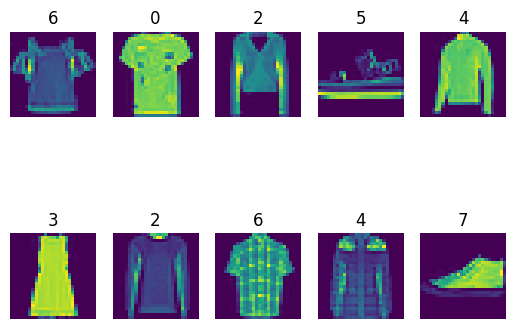

In [ ]:
#lets visualize few images
sample = np.random.randint(0,high= 59999, size=10)
print(sample)
sample_img = X_train[sample, :]
sample_label = Y_train[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,5,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img)
plt.show()


In [ ]:
#Defining constants
epochs = 5
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [ ]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [ ]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same',
           kernel_initializer='he_normal',
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 14, 14, 64)           0         ['batch_normalization[0][0

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/content/saved_model/fmnist_resnet_model.h5


In [ ]:
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [ ]:
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Not using data augmentation.
Epoch 1/5
599/600 [============================>.] - ETA: 0s - loss: 1.2046 - accuracy: 0.8469
Epoch 1: val_loss improved from inf to 0.89918, saving model to /content/saved_model/fmnist_resnet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 49s 44ms/step - loss: 1.2042 - accuracy: 0.8469 - val_loss: 0.8992 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 2/5
599/600 [============================>.] - ETA: 0s - loss: 0.7672 - accuracy: 0.8956
Epoch 2: val_loss improved from 0.89918 to 0.74907, saving model to /content/saved_model/fmnist_resnet_model.h5
600/600 [==============================] - 26s 43ms/step - loss: 0.7670 - accuracy: 0.8957 - val_loss: 0.7491 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 3/5
600/600 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.9093
Epoch 3: val_loss improved from 0.74907 to 0.56950, saving model to /content/saved_model/fmnist_resnet_model.h5
600/600 [==============================] - 26s 44ms/step - loss: 0.5931 - accuracy: 0.9093 - val_loss: 0.5695 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 4/5
600/600 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.9190
Epoch 4: val_loss improved from 0.56950 to 0.55505, s

In [ ]:
test_loss,test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

313/313 [==============================] - 4s 8ms/step - loss: 0.4980 - accuracy: 0.8988
Test loss: 0.4979650378227234
Test accuracy: 0.8988000154495239


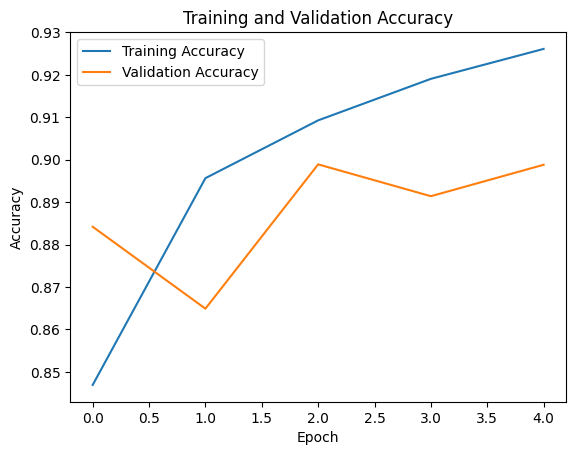

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



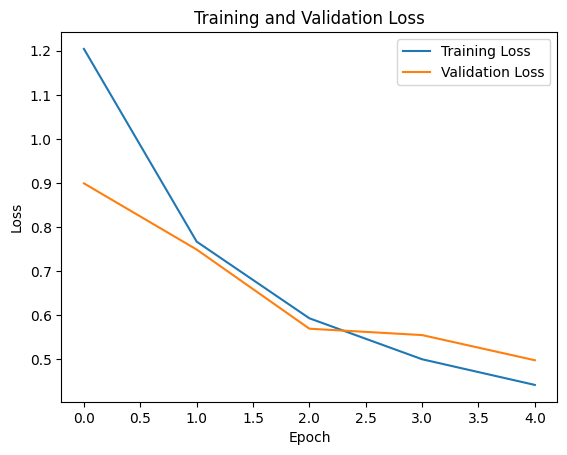

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()